IMPORTS

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Lambda, Activation, concatenate, RepeatVector
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
import tensorflow_probability as tfp
from sklearn.preprocessing import StandardScaler, LabelEncoder
from jinja2 import Template
import matplotlib.pyplot as plt
import os
!pip install scapy
from scapy.all import rdpcap , IP, TCP
from google.colab import drive
import ipaddress
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.losses import Loss
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from datetime import datetime
import inspect
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 6.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for scapy: filename=scapy-2.5.0-py2.py3-none-any.whl size=1444326 sha256=ff529eab63c8124b96941b915ba2c141cecef0259d7f812e9f49dcfbeb86f3cc
  Stored in directory: /root/.cache/pip/wheels/82/b7/03/8344d8cf6695624746311bc0d389e9d05535ca83c35f90241d
Successfully built scapy


converting wireshark logs file into csv

In [2]:
drive.mount('/content/drive')
packets = rdpcap('/content/drive/MyDrive/Study_DFs/network_logs.pcap')

Mounted at /content/drive


func extracting data

In [3]:
def extract_packet_info(packet):
    packet_info = {
        'time': packet.time,
        'src_ip': packet[IP].src if IP in packet else None,
        'dst_ip': packet[IP].dst if IP in packet else None,
        'src_mac': packet.src ,
        'dst_mac': packet.dst ,
        'src_port': packet[TCP].sport if TCP in packet else None, # Check if TCP layer is present
        'dst_port': packet[TCP].dport if TCP in packet else None, # Check if TCP layer is present
        'protocol': packet[0][1].proto , # Changed 1 to IP
        'length': len(packet),
        'tcp_flags': packet.sprintf('%TCP.flags%') ,
        'ttl': packet[IP].ttl if IP in packet else None,
        'id': packet[IP].id if IP in packet else None,
        'seq': packet[TCP].seq if TCP in packet else None, # Check if TCP layer is present
        'ack': packet[TCP].ack if TCP in packet else None, # Check if TCP layer is present
        'payload': packet.payload
    }
    return packet_info

func for processing the data

In [4]:
flag_values = {
    'F': 1,
    'S': 2,
    'R': 4,
    'P': 8,
    'A': 16,
    'Unknown': 32  # Assign a value for Unknown
}

scaler = MinMaxScaler()

def convert_flags_to_num(flags):
    num_value = 0
    if '??' in flags:
        num_value += flag_values['Unknown']
    for flag in flag_values:
        if flag in flags:
            num_value += flag_values[flag]
    return num_value

def processing_data(df):
  unique_flags = sorted(set(flag for flags in df['tcp_flags'] for flag in flags if flag != '?'))
  print(unique_flags)
  df['tcp_flags'] = df['tcp_flags'].apply(convert_flags_to_num)
  df['src_port_missing'] = df['src_port'].isnull().astype(int)
  df['dst_port_missing'] = df['dst_port'].isnull().astype(int)
       # Then fill the original columns with -1
  df['src_port'].fillna(-1, inplace=True)
  df['dst_port'].fillna(-1, inplace=True)
  df['seq_missing'] = df['seq'].isnull().astype(int)
  df['ack_missing'] = df['ack'].isnull().astype(int)
  df['seq'].fillna(-1, inplace=True)
  df['ack'].fillna(-1, inplace=True)
  nan_columns = df.columns[df.isna().any()].tolist()
  if len(nan_columns) ==0:
    print("No NaN colums left")
  else:
    print("all good")
  df['src_mac'] = df['src_mac'].apply(lambda x: int(x.replace(':', ''), 16) if x is not None else -1)
  df['dst_mac'] = df['dst_mac'].apply(lambda x: int(x.replace(':', ''), 16) if x is not None else -1)
  df['src_ip'] = df['src_ip'].apply(lambda x: int(ipaddress.IPv4Address(x)) if x is not None else -1)
  df['dst_ip'] = df['dst_ip'].apply(lambda x: int(ipaddress.IPv4Address(x)) if x is not None else -1)
  if 'ttl' in df.columns:
    df.drop(columns=['ttl'], inplace=True)
  if 'payload' in df.columns:
    df.drop(columns=['payload'], inplace=True)
  df[['seq', 'ack']] = scaler.fit_transform(df[['seq', 'ack']])

Incidents db

In [40]:
incidents_database = [
    {
        "type": "DNS Tunneling",
        "description": "Possible DNS tunneling detected",
        "criteria": {
            "protocol": 17,  # UDP
            "src_port": 53,  # DNS port
            "length": lambda x: x > 1000  # Example threshold for suspicious DNS queries
        },
        "recommendation": "Monitor and restrict DNS traffic, use DNS over HTTPS (DoH) or DNS over TLS (DoT) for secure DNS queries."
    },
    {
        "type": "DDoS Attack",
        "description": "Possible DDoS attack detected based on high packet rate",
        "criteria": {
            "src_ip": lambda x, df: df[df['src_ip'] == x].shape[0] > 1000  # High number of packets from a single IP
        },
        "recommendation": "Implement rate limiting, use DDoS mitigation services, and apply network traffic analysis to identify and block malicious IPs."
    },
    {
        "type": "Data Exfiltration",
        "description": "Potential data exfiltration detected",
        "criteria": {
            "dst_port": 21,  # FTP port
            "length": lambda x: x > 1000  # Large packet size
        },
        "recommendation": "Monitor and log all FTP traffic, restrict FTP usage to necessary accounts, and use secure file transfer protocols."
    },
    {
        "type": "Brute Force Login Attempt",
        "description": "Multiple failed login attempts detected",
        "criteria": {
            "src_port": 22,  # SSH port
            "tcp_flags": lambda x: x & flag_values['R']  # Reset flag indicating failed attempts
        },
        "recommendation": "Implement account lockout policies, use multi-factor authentication (MFA), and deploy intrusion detection/prevention systems (IDS/IPS)."
    },
    {
        "type": "IP Fragmentation Attack",
        "description": "Possible IP fragmentation attack detected",
        "criteria": {
            "protocol": 4,  # IPv4
            "length": lambda x: x < 400  # Small packet size
        },
        "recommendation": "Configure firewalls to block suspicious fragmented packets and use anti-fragmentation settings in network devices."
    },
    {
        "type": "ARP Spoofing",
        "description": "Possible ARP spoofing detected",
        "criteria": {
            "src_mac": lambda x, df: df[df['src_mac'] == x].shape[0] > 50  # Unusually high number of packets from a single MAC
        },
        "recommendation": "Use static ARP entries, enable ARP inspection on switches, and employ network monitoring tools to detect anomalies."
    },
    {
        "type": "Ping of Death",
        "description": "Large ICMP packet detected (possible Ping of Death attack)",
        "criteria": {
            "protocol": 1,  # ICMP
            "length": lambda x: x > 65535
        },
        "recommendation": "Block oversized ICMP packets at the firewall and limit ICMP traffic using rate limiting."
    },
    {
        "type": "Telnet Brute Force",
        "description": "Multiple failed Telnet login attempts detected",
        "criteria": {
            "src_port": 23,  # Telnet port
            "tcp_flags": lambda x: x & flag_values['R']  # Reset flag indicating failed attempts
        },
        "recommendation": "Disable Telnet in favor of SSH, implement account lockout policies, and use strong password policies."
    },
    {
        "type": "Port Scan",
        "description": "Multiple connection attempts to different ports detected",
        "criteria": {
            "src_ip": lambda x, df: df[df['src_ip'] == x]['dst_port'].nunique() > 100  # Many different destination ports
        },
        "recommendation": "Use port scan detection tools, block offending IP addresses, and limit the exposure of unnecessary services."
    },
    {
        "type": "SMB Traffic",
        "description": "Significant SMB traffic detected, potential for lateral movement",
        "criteria": {
            "dst_port": 445,  # SMB port
            "length": lambda x: x > 1000  # Large packet size
        },
        "recommendation": "Restrict SMB traffic, use SMB encryption, and regularly update and patch SMB services."
    },
    {
        "type": "NTP Amplification Attack",
        "description": "Possible NTP amplification attack detected",
        "criteria": {
            "src_port": 123,  # NTP port
            "length": lambda x: x > 1000  # Large packet size
        },
        "recommendation": "Implement rate limiting on NTP requests, use NTP servers with proper access control, and monitor for abnormal NTP traffic."
    },
    {
        "type": "DHCP Starvation Attack",
        "description": "Multiple DHCP requests from a single MAC address detected",
        "criteria": {
            "src_mac": lambda x, df: df[(df['src_mac'] == x) & (df['src_port'] == 67)].shape[0] > 50  # Many DHCP requests
        },
        "recommendation": "Implement DHCP snooping, use static IP assignments for critical devices, and monitor DHCP logs for anomalies."
    },
    {
        "type": "SQL Injection",
        "description": "Possible SQL injection attempt detected",
        "criteria": {
            "dst_port": 80,  # HTTP port
            "length": lambda x: x > 500  # Large request size (indicative of SQL query)
        },
        "recommendation": "Use web application firewalls (WAF), perform regular code reviews, and use parameterized queries and input validation."
    },
    {
        "type": "LDAP Injection",
        "description": "Possible LDAP injection attempt detected",
        "criteria": {
            "dst_port": 389,  # LDAP port
            "length": lambda x: x > 500  # Large request size (indicative of LDAP query)
        },
        "recommendation": "Use secure LDAP (LDAPS), validate and sanitize inputs, and employ intrusion detection systems (IDS)."
    },
    {
        "type": "ICMP Flood",
        "description": "High rate of ICMP packets detected",
        "criteria": {
            "protocol": 1,  # ICMP
            "src_ip": lambda x, df: df[(df['src_ip'] == x) & (df['protocol'] == 1)].shape[0] > 1000  # Many ICMP packets from single source
        },
        "recommendation": "Implement ICMP rate limiting, block unnecessary ICMP traffic, and use DDoS mitigation tools."
    },
    {
        "type": "Malicious User Agent",
        "description": "Potential malicious user agent string detected in HTTP request",
        "criteria": {
            "dst_port": 80,  # HTTP port
            "length": lambda x: x > 500  # Large request size (indicative of suspicious activity)
        },
        "recommendation": "Monitor and log user agent strings, block suspicious user agents, and use web application firewalls (WAF)."
    },
    {
        "type": "MSSQL Brute Force",
        "description": "Multiple failed MSSQL login attempts detected",
        "criteria": {
            "dst_port": 1433,  # MSSQL port
            "tcp_flags": lambda x: x & flag_values['R']  # Reset flag indicating failed attempts
        },
        "recommendation": "Implement account lockout policies, use multi-factor authentication (MFA), and regularly update and patch MSSQL servers."
    },
    {
        "type": "FTP Bounce Attack",
        "description": "Possible FTP bounce attack detected",
        "criteria": {
            "dst_port": 21,  # FTP port
            "length": lambda x: x > 1000  # Large packet size
        },
        "recommendation": "Restrict FTP access, use secure file transfer protocols, and monitor FTP logs for unusual activity."
    },
    {
        "type": "Reverse Shell",
        "description": "Possible reverse shell connection detected",
        "criteria": {
            "src_port": 4444,  # Common reverse shell port
            "length": lambda x: x > 1000  # Large packet size
        },
        "recommendation": "Block common reverse shell ports, monitor outbound connections, and use endpoint detection and response (EDR) tools."
    },
    {
        "type": "Web Shell",
        "description": "Possible web shell activity detected",
        "criteria": {
            "dst_port": 80,  # HTTP port
            "length": lambda x: x > 1000  # Large request size (indicative of web shell commands)
        },
        "recommendation": "Use web application firewalls (WAF), monitor web server logs, and perform regular security assessments."
    },
    {
        "type": "Suspicious MAC Address",
        "description": "Suspicious MAC address detected",
        "criteria": {
            "src_mac": lambda x: x.startswith('00:00:5e')  # Example prefix for suspicious MAC addresses
        },
        "recommendation": "Monitor and log MAC addresses, use network access control (NAC) to enforce device authentication, and block suspicious MAC addresses."
    },
    {
        "type": "Malicious SSL Certificate",
        "description": "ET TROJAN ABUSE.CH SSL Blacklist Malicious SSL certificate detected (Dridex)",
        "criteria": {
            "src_ip": "216.239.94.252",
            "protocol": 6,  # TCP
            "src_port": 443  # HTTPS port
        },
        "recommendation": "Block IP addresses associated with malicious SSL certificates, use SSL/TLS inspection, and monitor SSL traffic for anomalies."
    },
    {
        "type": "Large Number of Connections",
        "description": "Potential port scan detected due to a large number of connections",
        "criteria": {
            "src_ip": lambda x, df: df[df['src_ip'] == x].shape[0] > 100  # Example threshold for large number of connections
        },
        "recommendation": "Implement rate limiting, use intrusion detection systems (IDS), and block IPs exhibiting suspicious behavior."
    },
    {
        "type": "SYN Flood",
        "description": "Possible SYN Flood attack detected",
        "criteria": {
            "tcp_flags": lambda x: x & flag_values['S'] and not (x & flag_values['A'])  # SYN flag set, ACK flag not set
        },
        "recommendation": "Use SYN cookies, implement rate limiting, and deploy DDoS mitigation solutions."
    },
    {
        "type": "Unknown TCP Flags",
        "description": "Unknown TCP flags detected",
        "criteria": {
            "tcp_flags": lambda x: x & flag_values['Unknown']
        },
        "recommendation": "Monitor for unusual TCP flags, use firewalls to block packets with invalid flags, and investigate the source of such packets."
    },
    {
        "type": "Reset (RST) Flag Detected",
        "description": "TCP Reset (RST) flag detected",
        "criteria": {
            "tcp_flags": lambda x: x & flag_values['R']
        },
        "recommendation": "Monitor and log reset flags, use intrusion detection systems (IDS), and investigate frequent occurrences."
    },
    {
        "type": "Finish (FIN) Flag Detected",
        "description": "TCP Finish (FIN) flag detected",
        "criteria": {
            "tcp_flags": lambda x: x & flag_values['F']
        },
        "recommendation": "Monitor and log finish flags, use firewalls to filter traffic, and investigate unusual patterns."
    },
    {
        "type": "Unusual Packet Length",
        "description": "Packet with unusual length detected",
        "criteria": {
            "length": lambda x: x > 1500
        },
        "recommendation": "Investigate the source of unusually large packets, use network monitoring tools, and ensure proper segmentation and filtering."
    },
    {
        "type": "Unusual Port Usage",
        "description": "Unusual port usage detected",
        "criteria": {
            "dst_port": lambda x: x not in range(1024)
        },
        "recommendation": "Restrict the use of high-numbered ports, monitor and log port usage, and implement firewall rules to control port access."
    }
]

Useful functions for converting values back (for report)

In [41]:
def convert_ip_back(num_ip):
    try:
        return str(ipaddress.IPv4Address(num_ip))
    except:
        return None

def convert_mac_back(num_mac):
    if pd.isna(num_mac) or num_mac == -1:  # Handle missing data
        return None
    try:
        # Ensure num_mac is an integer
        num_mac = int(num_mac)
        # Format the MAC address as 12 hexadecimal digits (or less if num_mac is too small)
        hex_str = f'{num_mac:012x}'[:12]
        # Split into pairs with colons
        mac_address = ':'.join(hex_str[i:i+2] for i in range(0, len(hex_str), 2))
        return mac_address
    except Exception as e:
        print(f"Error converting MAC: {e}, Value: {num_mac}")
        return None

Model Definition

In [48]:
class AutoencoderModel:
    def __init__(self, input_shape, encoding_dim, learning_rate=0.001):
        self.input_shape = input_shape
        self.encoding_dim = encoding_dim
        self.learning_rate = learning_rate
        self.model, self.encoder = self.build_model()
        self.model.compile(optimizer=Adam(learning_rate=self.learning_rate), loss='mse')

    def build_model(self):
        inputs = Input(shape=self.input_shape)
        x = LSTM(128, activation='relu', return_sequences=True)(inputs)
        x = LSTM(self.encoding_dim, activation='relu')(x)
        x = RepeatVector(self.input_shape[0])(x)
        x = LSTM(128, activation='relu', return_sequences=True)(x)
        outputs = LSTM(self.input_shape[1], activation='sigmoid', return_sequences=True)(x)
        model = Model(inputs, outputs)
        encoder = Model(inputs, x)
        return model, encoder

    def train(self, X_train, epochs, batch_size, validation_split):
        early_stopping = EarlyStopping(monitor='val_loss', patience=100, restore_best_weights=True)
        history = self.model.fit(X_train, X_train, epochs=epochs, batch_size=batch_size, validation_split=validation_split, callbacks=[early_stopping])
        return history

    def detect_anomalies(self, X_test):
        reconstructions = self.model.predict(X_test)
        mse = np.mean(np.square(X_test - reconstructions), axis=1)
        pi, mu, sigma = self.calculate_pi_mu_sigma(reconstructions, X_test)
        anomalies, threshold = self.detect_anomalies_from_stats(mse, mu, sigma)
        return mse, anomalies, threshold

    def calculate_pi_mu_sigma(self, reconstructions, X_test):
        mse = np.mean(np.square(X_test - reconstructions), axis=1)
        pi = np.mean(mse)
        mu = np.mean(mse)
        sigma = np.std(mse)
        return pi, mu, sigma

    def detect_anomalies_from_stats(self, mse, mu, sigma):
        threshold = mu + 3 * sigma  # using 3-sigma rule for anomalies
        anomalies = mse > threshold
        return anomalies, threshold

    def plot_reconstruction_error(self, mse, threshold):
        plt.figure(figsize=(10, 6))
        plt.plot(mse, label='Reconstruction Error')
        plt.axhline(y=threshold, color='r', linestyle='--', label='Threshold')
        plt.xlabel('Sample Index')
        plt.ylabel('Reconstruction Error')
        plt.title('Anomaly Detection')
        plt.legend()
        plt.show()

    def get_reconstruction_error(self, X):
        reconstructions = self.model.predict(X)
        mse = np.mean(np.square(X - reconstructions), axis=1)
        return mse

    def match_incidents(self, row, df):
        for incident in incidents_database:
            match = True
            for key, criterion in incident['criteria'].items():
                if callable(criterion):
                    num_args = len(inspect.signature(criterion).parameters)
                    if num_args == 1:
                        if not criterion(row[key]):
                            match = False
                            break
                    elif num_args == 2:
                        if not criterion(row[key], df):
                            match = False
                            break
                else:
                    if row[key] != criterion:
                        match = False
                        break
            if match:
                 return incident['description'],incident['recommendation']
        return "Unusual activity detected" , "Ask your technician"

    # Function to analyze and generate a detailed report for each anomaly
    def analyze_anomalies(self,anomalous_data, df):
        reports = []
        for idx, row in anomalous_data.iterrows():
            event_id = idx
            count = 1  # Each row is a unique event
            timestamp = row['time']

            # Match against the incident database
            description,recommendation = self.match_incidents(row, df)

            # Compile the report details
            report_details = [
                f"Event#{event_id} {timestamp}",
                description,
                f"{convert_ip_back(row['src_ip'])} -> {convert_ip_back(row['dst_ip'])}",
                f"IPVer=4 hlen=5 tos=0 dlen={row['length']} ID={row['id']} flags=0 offset=0 ttl=0 chksum=0",
                f"Protocol: {row['protocol']} sport={row['src_port']} -> dport={row['dst_port']}",
                f"Seq={row['seq']} Ack={row['ack']} Off=5 Res=0 Flags={row['tcp_flags']}",
                recommendation,
                "------------------------------------------------------------------------"
            ]

            report = "\n".join(report_details)
            reports.append(report)
        return reports

Extract and read data

In [50]:
packet_data = [extract_packet_info(packet) for packet in packets]

# Создание DataFrame из извлеченной информации
df = pd.DataFrame(packet_data)

# Сохранение DataFrame в CSV файл
df.to_csv('output.csv', index=False)
df = pd.read_csv('output.csv')
processing_data(df)
df

['A', 'F', 'P', 'R', 'S']
No NaN colums left


,time,src_ip,dst_ip,src_mac,dst_mac,src_port,dst_port,protocol,length,tcp_flags,id,seq,ack,src_port_missing,dst_port_missing,seq_missing,ack_missing
0,1.548712e+09,2886797421,2886797567,23084204824010,281474976710655,-1.0,-1.0,17,110,32,9,-1.309540,-1.545162,1,1,1,1
1,1.548712e+09,2886797421,2886797567,23084204824010,281474976710655,-1.0,-1.0,17,110,32,10,-1.309540,-1.545162,1,1,1,1
2,1.548712e+09,2886797421,2886797314,23084204824010,143318490804,-1.0,-1.0,17,97,32,12,-1.309540,-1.545162,1,1,1,1
3,1.548712e+09,2886797314,2886797421,143318490804,23084204824010,-1.0,-1.0,17,164,32,14525,-1.309540,-1.545162,1,1,1,1
4,1.548712e+09,2886797421,2886797314,23084204824010,143318490804,-1.0,-1.0,17,91,32,13,-1.309540,-1.545162,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3685,1.548713e+09,2886797421,3639566076,23084204824010,19769387789,49234.0,443.0,6,54,16,1644,0.901514,-0.030943,0,0,0,0
3686,1.548713e+09,3639566076,2886797421,19769387789,23084204824010,443.0,49234.0,6,54,25,42450,0.219548,0.644392,0,0,0,0
3687,1.548713e+09,2886797421,3639566076,23084204824010,19769387789,49234.0,443.0,6,54,16,1645,0.901514,-0.030943,0,0,0,0
3688,1.548713e+09,2886797421,3639566076,23084204824010,19769387789,49234.0,443.0,6,54,17,1646,0.901514,-0.030943,0,0,0,0


Preparing data and training

In [51]:
def prepare_data(df, target_columns):
    X = df.drop(columns=target_columns)
    y = df[target_columns]
    return X, y

Epoch 1/100
47/47 [==============================] - 10s 99ms/step - loss: 0.9049 - val_loss: 0.7924
Epoch 2/100
47/47 [==============================] - 2s 47ms/step - loss: 0.7838 - val_loss: 0.7552
Epoch 3/100
47/47 [==============================] - 2s 48ms/step - loss: 0.8648 - val_loss: 0.8487
Epoch 4/100
47/47 [==============================] - 2s 51ms/step - loss: 0.8628 - val_loss: 0.8304
Epoch 5/100
47/47 [==============================] - 2s 48ms/step - loss: 0.8399 - val_loss: 0.8476
Epoch 6/100
47/47 [==============================] - 4s 89ms/step - loss: 0.8483 - val_loss: 0.8032
Epoch 7/100
47/47 [==============================] - 3s 61ms/step - loss: 0.8254 - val_loss: 0.7949
Epoch 8/100
47/47 [==============================] - 2s 49ms/step - loss: 0.8212 - val_loss: 0.7935
Epoch 9/100
47/47 [==============================] - 2s 47ms/step - loss: 0.8214 - val_loss: 0.7926
Epoch 10/100
47/47 [==============================] - 2s 47ms/step - loss: 0.8203 - val_loss: 0.792

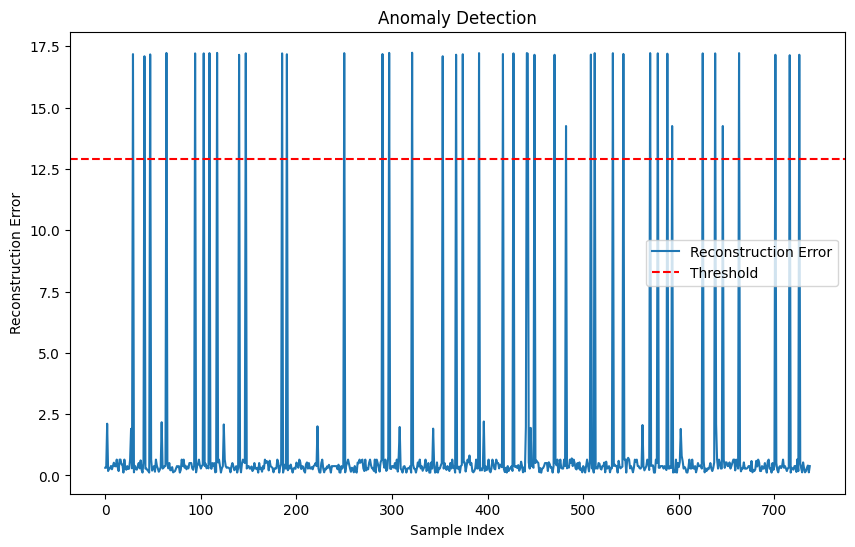

In [52]:
features = ['protocol', 'length', 'tcp_flags', 'seq', 'ack', 'src_port_missing', 'dst_port_missing', 'seq_missing', 'ack_missing']
X = df[features]

# 2. Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test = train_test_split(X_scaled, test_size=0.2, random_state=42)

# 3. Reshape for LSTM
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))


# Initialize and train the model
autoencoder = AutoencoderModel(input_shape=(X_train.shape[1], X_train.shape[2]), encoding_dim=32)
autoencoder.train(X_train, epochs=100, batch_size=32, validation_split=0.5)


# Detect anomalies
mse, anomalies, threshold = autoencoder.detect_anomalies(X_test)
anomaly_indices = np.where(anomalies)[0]
anomalous_data = df.iloc[X_test.shape[0] - len(X_test) + anomaly_indices]

# Display the anomalies
print("Anomalies detected:")
print(anomalous_data[['time', 'src_ip', 'dst_ip', 'src_mac', 'dst_mac', 'src_port', 'dst_port', 'protocol', 'length', 'tcp_flags', 'id', 'seq', 'ack']])

# Optional: Plot reconstruction error
autoencoder.plot_reconstruction_error(mse, threshold)

Converting the results for anomalies back

In [53]:
anomalous_data['time'] = pd.to_datetime(anomalous_data['time'], unit='s')
anomalous_data['src_ip'] = anomalous_data['src_ip'].apply(convert_ip_back)
anomalous_data['dst_ip'] = anomalous_data['dst_ip'].apply(convert_ip_back)
anomalous_data['src_mac'] = anomalous_data['src_mac'].apply(convert_mac_back)
anomalous_data['dst_mac'] = anomalous_data['dst_mac'].apply(convert_mac_back)

# Display the anomalies with original formatting
print("Anomalies detected:")
print(anomalous_data[['time', 'src_ip', 'dst_ip', 'src_mac', 'dst_mac', 'src_port', 'dst_port', 'protocol', 'length', 'tcp_flags', 'id', 'seq', 'ack']])

Anomalies detected:
                             time        src_ip        dst_ip  \
29  2019-01-28 21:44:14.202793984    172.17.8.2  172.17.8.109   
41  2019-01-28 21:44:14.207154944  172.17.8.109    172.17.8.2   
47  2019-01-28 21:44:14.208275968  172.17.8.109    172.17.8.2   
64  2019-01-28 21:44:14.240692992  172.17.8.109    172.17.8.2   
94  2019-01-28 21:44:14.291858944    172.17.8.2  172.17.8.109   
103 2019-01-28 21:44:14.294814976  172.17.8.109    172.17.8.2   
109 2019-01-28 21:44:14.295526144  172.17.8.109    172.17.8.2   
117 2019-01-28 21:44:14.297327104    172.17.8.2  172.17.8.109   
140 2019-01-28 21:44:14.415638016    172.17.8.2  172.17.8.109   
147 2019-01-28 21:44:14.417350912  172.17.8.109    172.17.8.2   
185 2019-01-28 21:44:15.160360960    172.17.8.2  172.17.8.109   
190 2019-01-28 21:44:15.160965888    172.17.8.2  172.17.8.109   
250 2019-01-28 21:44:15.370419968  172.17.8.109    172.17.8.2   
290 2019-01-28 21:44:15.415376896    172.17.8.2  172.17.8.109   
297 2

<ipython-input-53-8a8c8e620dc3>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  anomalous_data['time'] = pd.to_datetime(anomalous_data['time'], unit='s')
<ipython-input-53-8a8c8e620dc3>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  anomalous_data['src_ip'] = anomalous_data['src_ip'].apply(convert_ip_back)
<ipython-input-53-8a8c8e620dc3>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats i

Generate report

In [54]:
anomaly_reports_with_db = autoencoder.analyze_anomalies(anomalous_data, df)

# Display the reports
for report in anomaly_reports_with_db:
    print(report)

Event#29 2019-01-28 21:44:14.202793984
Unusual port usage detected
172.17.8.2 -> 172.17.8.109
IPVer=4 hlen=5 tos=0 dlen=66 ID=14537 flags=0 offset=0 ttl=0 chksum=0
Protocol: 6 sport=88.0 -> dport=49158.0
Seq=1.6446938208220616 Ack=-0.7582874259130351 Off=5 Res=0 Flags=18
Restrict the use of high-numbered ports, monitor and log port usage, and implement firewall rules to control port access.
------------------------------------------------------------------------
Event#41 2019-01-28 21:44:14.207154944
Packet with unusual length detected
172.17.8.109 -> 172.17.8.2
IPVer=4 hlen=5 tos=0 dlen=1514 ID=33 flags=0 offset=0 ttl=0 chksum=0
Protocol: 6 sport=49159.0 -> dport=88.0
Seq=-0.6086897518668111 Ack=1.4213044570002495 Off=5 Res=0 Flags=16
Investigate the source of unusually large packets, use network monitoring tools, and ensure proper segmentation and filtering.
------------------------------------------------------------------------
Event#47 2019-01-28 21:44:14.208275968
TCP Finish (FIN

Now generating an HTML report

In [55]:
# Generate HTML report
html_template = Template("""
<!DOCTYPE html>
<html>
<head>
<title>Anomaly Detection Report</title>
<style>
body {
    font-family: sans-serif;
}
table {
    border-collapse: collapse;
    width: 100%;
}
th, td {
    border: 1px solid black;
    padding: 8px;
    text-align: left;
}
</style>
</head>
<body>
<h1>Anomaly Detection Report</h1>
{% for report in anomaly_reports %}
<pre>{{ report }}</pre>
{% endfor %}
</body>
</html>
""")

html_output = html_template.render(anomaly_reports=anomaly_reports_with_db)

# Save to HTML file
with open("anomaly_report.html", "w") as f:
    f.write(html_output)

print("Anomaly report saved to anomaly_report.html")

Anomaly report saved to anomaly_report.html


saving weights of a model

In [27]:
model_save_path = 'model_weights.h5'
autoencoder.model.save_weights(model_save_path)